In [76]:
from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 

In [77]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys
from urllib.error import *


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    # 50000 training set
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    # 10000 test set
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


def get_file(fname,
             origin,
             untar=False,
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)

    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    return fpath


def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def rgb2label(rgb_images, colours, batch_size):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _rgb2label
    Args:
      rgb_images: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
      batch_size: int value to determine size of batch
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(rgb_images)[0] < batch_size:
        return _rgb2label(rgb_images)
    nexts = []
    for i in range(0, np.shape(rgb_images)[0], batch_size):
        next = _rgb2label(rgb_images[i:i + batch_size, :, :, :], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result


def _rgb2label(rgb_images, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `rgb_images`. This function is a little memory
    intensive, and so the size of `rgb_images` should not be too large.
    Args:
      rgb_images: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    rgb_images = np.expand_dims(rgb_images, 0)
    cs = np.reshape(colours, [num_colours, 1, 3, 1, 1])
    # Calculate distance
    dists = np.linalg.norm(rgb_images - cs, axis=2)  # 2 = colour axis
    label = np.argmin(dists, axis=0)
    label = np.expand_dims(label, axis=1)
    return label


def cat2rgb(labels, colours):
    """
    Get RGB colours given the colour categories
    Args:
      labels: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[labels]


def process(xs, ys, max_pixel=256.0, downsize_input=False):

    """
    Pre-process CIFAR10 images by taking only the car category,
    shuffling, and have colour values be bound between 0 and 1
    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      category_id: int value as the id of each category in CIFAR10 dataset
      max_pixel: maximum pixel value in the original data
      downsize_input: boolean value
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    category_id = 1
    xs = xs / max_pixel
    xs = xs[np.where(ys == category_id)[0], :, :, :]
    np.random.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                        nn.AvgPool2d(2),
                                        nn.Upsample(scale_factor=2),
                                        nn.Upsample(scale_factor=2))
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return xs, xs_downsized
    else:
        return xs, grey


def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs (10 samples you can change this value)
    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10, :, :, :], [0, 2, 3, 1])
    gtcolor = cat2rgb(gtlabel[:10, 0, :, :], colours)
    predcolor = cat2rgb(output[:10, 0, :, :], colours)

    img_stack = [
        np.hstack(np.tile(grey, [1, 1, 1, 3])),
        np.hstack(gtcolor),
        np.hstack(predcolor)]

    if compare_bilinear:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                        nn.AvgPool2d(2),
                                        nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Upsample(scale_factor=2, mode='bilinear'))
        gt_input = np.transpose(gtcolor, [0, 3, 1, 2, ])
        color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(input[:10, :, :, :], [0, 2, 3, 1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilinear)]
    img = np.vstack(img_stack)

    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)

In [78]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/a2/
%cd /content/csc413/a2

######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

/content/csc413/a2


In [79]:
import torch

In [80]:
colours_dic_addr = '/content/car_colours_kmeans24.npy'

In [81]:
# Download CIFAR dataset
(x_train, y_train), (x_test, y_test) = load_cifar10()

# LOAD THE COLOURS CATEGORIES
colours = np.load(colours_dic_addr, allow_pickle=True, encoding='bytes')

File path: data/cifar-10-batches-py.tar.gz


In [82]:
from torch.autograd import Variable
#from utils import *


# You can add any function here if needed in the training process

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data
    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i + batch_size, :, :, :]
        batch_y = y[i:i + batch_size, :, :, :]
        yield batch_x, batch_y


def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.
    Args:
      xs (float numpy tensor): greyscale input
      ys (int numpy tensor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


# You can implement the model evaluation process in this function
def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    val_accs = np.float64(100 * correct / total)
    return val_loss, val_acc, val_accs
    None

In [88]:
######################################################################
# MODELS
######################################################################

class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        self.firstLayer = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel, padding=padding),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        self.secondLayer = nn.Sequential(
            MyConv2d(num_filters, 2*num_filters, kernel, padding=padding),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        )

        self.thirdLayer = nn.Sequential(
            MyConv2d(2*num_filters, 2*num_filters, kernel, padding=padding),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        )

        self.fourthLayer = nn.Sequential(
            MyConv2d(2*num_filters, num_filters, kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        self.fifthLayer = nn.Sequential(
            MyConv2d(num_filters, num_colours, kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
        )

        self.sixthLayer = MyConv2d(num_colours, num_colours, kernel, padding=padding)

    def forward(self, x):
        first = self.firstLayer(x)
        second = self.secondLayer(first)
        third = self.thirdLayer(second)
        fourth = self.fourthLayer(third)
        fifth = self.fifthLayer(fourth)
        output = self.sixthLayer(fifth)
        return output


class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()

        self.firstLayer = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        self.secondLayer = nn.Sequential(
            MyConv2d(num_filters, 2*num_filters, kernel),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        )

        self.thirdLayer = nn.Sequential(
            MyConv2d(2*num_filters, 2*num_filters, kernel),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        )

        self.fourthLayer = nn.Sequential(
            MyConv2d(2*2*num_filters, num_filters, kernel),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        self.fifthLayer = nn.Sequential(
            MyConv2d(2*num_filters, num_colours, kernel),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
        )

        self.sixthLayer = MyConv2d(num_colours+num_in_channels, num_colours, kernel)

    def forward(self, x):
        first = self.firstLayer(x)
        second = self.secondLayer(first)
        third = self.thirdLayer(second)
        fourth = self.fourthLayer(torch.cat([second, third], dim=1))
        fifth = self.fifthLayer(torch.cat([first, fourth], dim=1))
        sixth = self.sixthLayer(torch.cat([x, fifth], dim=1))
        return sixth


class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels, enc_or_dec='encoder'):
        super(SkipConnection, self).__init__()
        self.enc_or_dec = enc_or_dec
        self.skip_encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride=2, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )

        self.skip_decoder = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        if self.enc_or_dec == 'encoder':
            return self.skip_encoder(x)
        if self.enc_or_dec == 'decoder':
            return self.skip_decoder(x)


class CustomUnetWithResiduals(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CustomUnetWithResiduals, self).__init__()

        self.firstLayer = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )
        self.skip_first_layer = SkipConnection(num_in_channels, num_filters, enc_or_dec='encoder')
       

        self.secondLayer = nn.Sequential(
            MyConv2d(num_filters, 2*num_filters, kernel),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        )
        self.skip_second_layer = SkipConnection(num_filters, num_filters * 2, enc_or_dec='encoder')

        self.thirdLayer = nn.Sequential(
            MyConv2d(2*num_filters, 2*num_filters, kernel),
            nn.BatchNorm2d(2*num_filters),
            nn.ReLU()
        )

        self.fourthLayer = nn.Sequential(
            MyConv2d(2*2*num_filters, num_filters, kernel),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )
        self.skip_fourth_layer = SkipConnection(num_filters * 2 * 2, num_filters, enc_or_dec='decoder')


        self.fifthLayer = nn.Sequential(
            MyConv2d(2*num_filters, num_colours, kernel),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
        )
        self.skip_fifth_layer = SkipConnection(num_filters * 2, num_colours, enc_or_dec='decoder')

        self.sixthLayer = MyConv2d(num_colours+num_in_channels, num_colours, kernel)

    def forward(self, x):
        first = self.firstLayer(x)
        skip = self.skip_first_layer(x)
        first = first + skip

        second = self.secondLayer(first)
        skip = self.skip_second_layer(first)
        second = second + skip

        third = self.thirdLayer(second)
        third = third + second

        fourth = self.fourthLayer(torch.cat([second, third], dim=1))
        skip = self.skip_fourth_layer(torch.cat([second, third], dim=1))
        fourth = fourth + skip

        fifth = self.fifthLayer(torch.cat([first, fourth], dim=1))
        skip = self.skip_fifth_layer(torch.cat([first, fourth], dim=1))
        fifth = fifth + skip

        sixth = self.sixthLayer(torch.cat([x, fifth], dim=1))
        return sixth



        

train

In [84]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    #TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(colours_dic_addr, allow_pickle=True, encoding='bytes')
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNetWithResidual":
          cnn = CustomUnetWithResiduals(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)
    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    valid_accss = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot and epoch==25:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            print("in epoch "+str(epoch)+" the gray, original and predicted image have shown below ")
            plt.imshow(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc, val_accs = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_accs)
       # valid_accss = np.mean(valid_accs)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.plot(train_losses, "r-", label="Train Loss")
    plt.plot(valid_losses, "b-", label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.savefig(save_dir+"/training_curve.png")
    plt.subplot(1,2,2)
    plt.plot(valid_accs, "g-", label="Validation Loss")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/valid_curve_acc.png")
    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

In [85]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]


In [86]:
def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

CNN

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.4481, Time (s): 0
Epoch [1/25], Val Loss: 2.4047, Val Acc: 23.6%, Time(s): 0.70
Epoch [2/25], Loss: 2.0643, Time (s): 1
Epoch [2/25], Val Loss: 2.1864, Val Acc: 28.5%, Time(s): 1.29
Epoch [3/25], Loss: 1.9794, Time (s): 1
Epoch [3/25], Val Loss: 1.9259, Val Acc: 34.5%, Time(s): 1.88
Epoch [4/25], Loss: 1.9158, Time (s): 2
Epoch [4/25], Val Loss: 1.9090, Val Acc: 34.5%, Time(s): 2.48
Epoch [5/25], Loss: 1.8823, Time (s): 2
Epoch [5/25], Val Loss: 1.8894, Val Acc: 35.2%, Time(s): 3.09
Epoch [6/25], Loss: 1.8495, Time (s): 3
Epoch [6/25], Val Loss: 1.8619, Val Acc: 35.3%, Time(s): 3.70
Epoch [7/25], Loss: 1.8252, Time (s): 4
Epoch [7/25], Val Loss: 1.8602, Val Acc: 35.3%, Time(s): 4.34
Epoch [8/25], Loss: 1.8066, Time (s): 4
Epoch [8/25], Val Loss: 1.8322, Val Acc: 35.7%, Time(s): 4.97
Epoch [9/25], Loss: 1.7905, Time (s): 5
Epoch [9/25], Val Loss: 1.8150, Val Acc: 

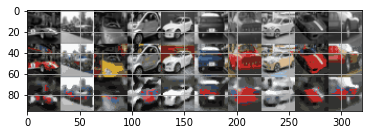

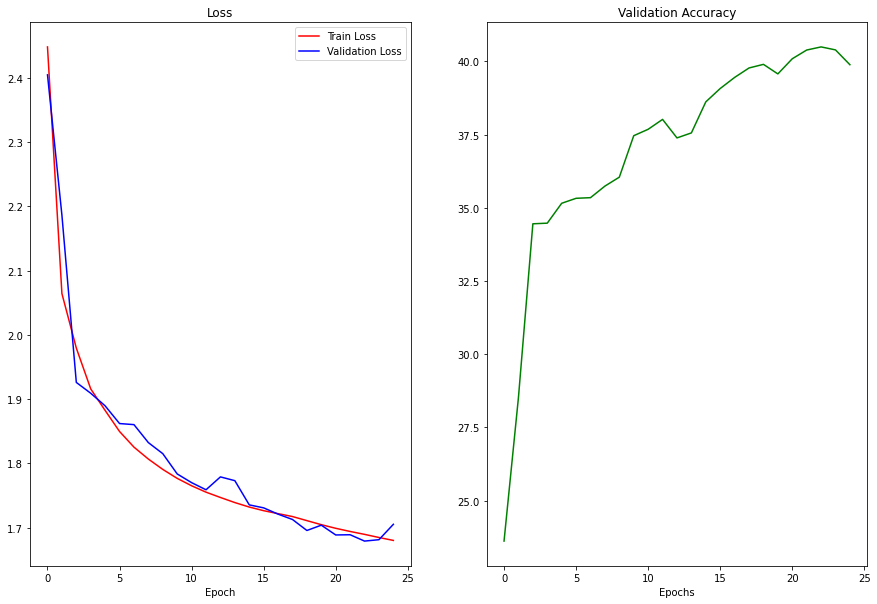

In [74]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'/content/car_colours_kmeans24.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':8, 
              'learn_rate':0.01, 
              'batch_size':200, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

Unet

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.1134, Time (s): 0
Epoch [1/25], Val Loss: 2.0249, Val Acc: 27.7%, Time(s): 0.73
Epoch [2/25], Loss: 1.6973, Time (s): 1
Epoch [2/25], Val Loss: 1.8022, Val Acc: 36.8%, Time(s): 1.33
Epoch [3/25], Loss: 1.6208, Time (s): 1
Epoch [3/25], Val Loss: 1.5779, Val Acc: 44.5%, Time(s): 1.94
Epoch [4/25], Loss: 1.5453, Time (s): 2
Epoch [4/25], Val Loss: 1.5449, Val Acc: 45.2%, Time(s): 2.56
Epoch [5/25], Loss: 1.5029, Time (s): 3
Epoch [5/25], Val Loss: 1.4660, Val Acc: 47.6%, Time(s): 3.18
Epoch [6/25], Loss: 1.4704, Time (s): 3
Epoch [6/25], Val Loss: 1.4556, Val Acc: 47.3%, Time(s): 3.83
Epoch [7/25], Loss: 1.4415, Time (s): 4
Epoch [7/25], Val Loss: 1.4259, Val Acc: 48.4%, Time(s): 4.47
Epoch [8/25], Loss: 1.4180, Time (s): 4
Epoch [8/25], Val Loss: 1.4213, Val Acc: 47.7%, Time(s): 5.12
Epoch [9/25], Loss: 1.3995, Time (s): 5
Epoch [9/25], Val Loss: 1.3746, Val Acc: 

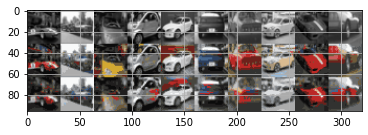

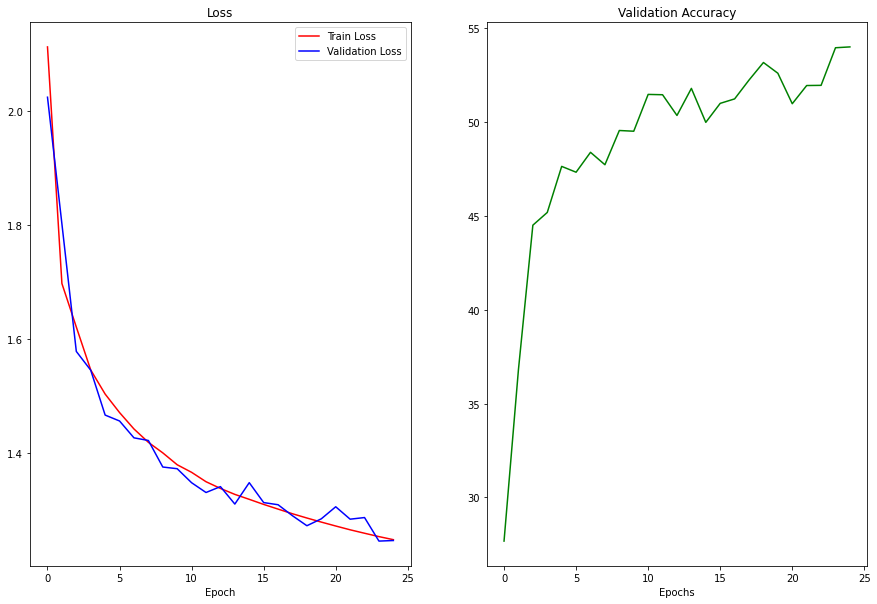

In [75]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'/content/car_colours_kmeans24.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':8, 
              'learn_rate':0.01, 
              'batch_size':200, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet = train(args)

In [ ]:
Extra Point

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.2279, Time (s): 0
Epoch [1/25], Val Loss: 2.4779, Val Acc: 18.4%, Time(s): 0.84
Epoch [2/25], Loss: 1.8204, Time (s): 1
Epoch [2/25], Val Loss: 1.8285, Val Acc: 36.8%, Time(s): 1.56
Epoch [3/25], Loss: 1.7033, Time (s): 2
Epoch [3/25], Val Loss: 1.7296, Val Acc: 39.9%, Time(s): 2.30
Epoch [4/25], Loss: 1.6397, Time (s): 2
Epoch [4/25], Val Loss: 1.6128, Val Acc: 44.5%, Time(s): 3.23
Epoch [5/25], Loss: 1.5957, Time (s): 3
Epoch [5/25], Val Loss: 1.5776, Val Acc: 45.6%, Time(s): 4.19
Epoch [6/25], Loss: 1.5529, Time (s): 4
Epoch [6/25], Val Loss: 1.5597, Val Acc: 45.3%, Time(s): 4.93
Epoch [7/25], Loss: 1.5142, Time (s): 5
Epoch [7/25], Val Loss: 1.4778, Val Acc: 49.3%, Time(s): 5.70
Epoch [8/25], Loss: 1.4843, Time (s): 6
Epoch [8/25], Val Loss: 1.4654, Val Acc: 48.9%, Time(s): 6.47
Epoch [9/25], Loss: 1.4591, Time (s): 7
Epoch [9/25], Val Loss: 1.4309, Val Acc: 

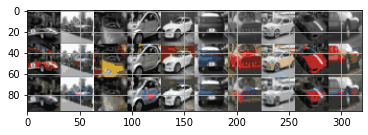

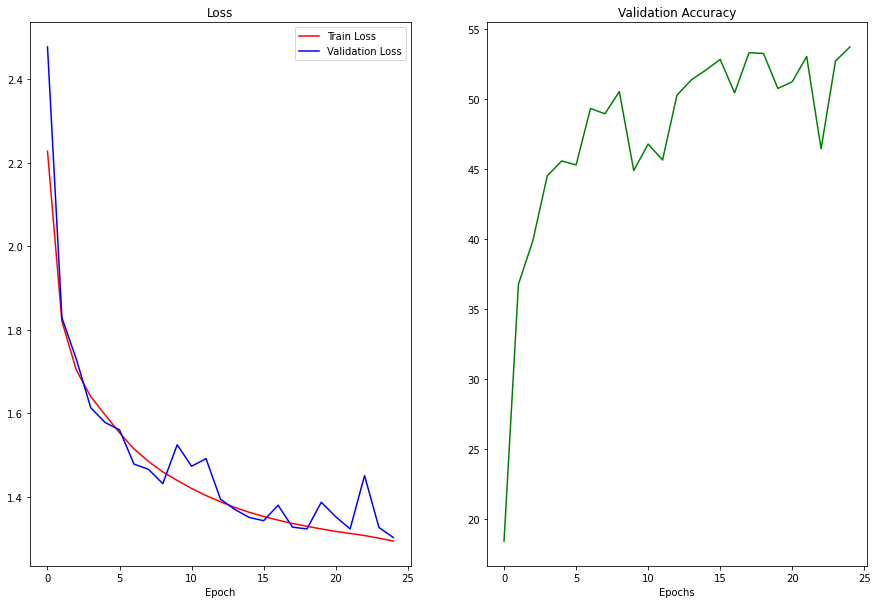

In [98]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'/content/car_colours_kmeans24.npy', 
              'model':"UNetWithResidual", 
              'kernel':3,
              'num_filters':8, 
              'learn_rate':0.0035, 
              'batch_size':200, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet = train(args)
